# Model Diagnostics & Improvement
# Finding and fixing issues with low accuracy

# %% [markdown]
# # Model Diagnostics - Why is Accuracy So Low?
# 
# Investigating:
# 1. Data quality issues
# 2. Feature effectiveness
# 3. Model bias
# 4. Alternative approaches

In [1]:
# %% Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# %% Cell 2: Load Data
features_df = pd.read_csv('../data/processed/features_engineered.csv')

# Get actual goals
import os, sys
sys.path.append('..')
from dotenv import load_dotenv
from database_manager import FootballDatabaseManager

load_dotenv()

db = FootballDatabaseManager(
    host=os.getenv('DB_HOST'),
    port=int(os.getenv('DB_PORT')),
    database=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD')
)

with db.get_cursor() as cursor:
    cursor.execute("SELECT match_id, home_goals, away_goals FROM matches")
    goals_df = pd.DataFrame(cursor.fetchall())

db.close()

data = features_df.merge(goals_df, on='match_id', how='left')
data['total_goals'] = data['home_goals'] + data['away_goals']
data['over_2_5'] = (data['total_goals'] > 2.5).astype(int)

print(f"Total matches: {len(data)}")

✓ Connected to PostgreSQL database: football_predictions
✓ Database connections closed
Total matches: 1085


In [3]:
# %% Cell 3: DIAGNOSIS 1 - Check for Data Leakage

print("\n" + "="*60)
print("DIAGNOSIS 1: CHECKING FOR DATA LEAKAGE")
print("="*60)

# Check if any features are suspiciously perfect predictors
exclude_cols = ['match_id', 'fixture_date', 'league_id', 'season', 
                'home_team_id', 'away_team_id', 'outcome', 'outcome_numeric',
                'home_goals', 'away_goals', 'total_goals', 'over_2_5']

feature_columns = [col for col in data.columns if col not in exclude_cols]
X = data[feature_columns].fillna(0)

# Check correlation of each feature with outcome
correlations = []
for col in feature_columns:
    corr = data[col].corr(data['outcome_numeric'])
    correlations.append({'feature': col, 'correlation': abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)

print("\nTop 10 Most Correlated Features:")
print(corr_df.head(10).to_string(index=False))

print("\nFeatures with suspiciously high correlation (>0.5):")
suspicious = corr_df[corr_df['correlation'] > 0.5]
if len(suspicious) > 0:
    print(suspicious.to_string(index=False))
    print("\n⚠️ WARNING: These features might indicate data leakage!")
else:
    print("✓ No suspicious correlations found")


DIAGNOSIS 1: CHECKING FOR DATA LEAKAGE

Top 10 Most Correlated Features:
                     feature  correlation
    form_goals_conceded_diff     0.115721
               form_ppg_diff     0.115002
away_form_avg_goals_conceded     0.105071
            form_points_diff     0.103085
      form_goals_scored_diff     0.101500
               away_form_ppg     0.091525
          away_form_win_rate     0.089591
            away_form_points     0.076827
              away_form_wins     0.074872
  home_form_avg_goals_scored     0.072794

Features with suspiciously high correlation (>0.5):
✓ No suspicious correlations found


In [4]:
# %% Cell 4: DIAGNOSIS 2 - Feature Value Distribution

print("\n" + "="*60)
print("DIAGNOSIS 2: FEATURE VALUE DISTRIBUTIONS")
print("="*60)

# Check if features have meaningful variance
feature_stats = X.describe().T
feature_stats['variance'] = X.var()
feature_stats = feature_stats.sort_values('variance', ascending=False)

print("\nFeatures with highest variance:")
print(feature_stats[['mean', 'std', 'variance']].head(10))

print("\nFeatures with near-zero variance (not useful):")
low_variance = feature_stats[feature_stats['variance'] < 0.01]
if len(low_variance) > 0:
    print(low_variance[['mean', 'std', 'variance']])
    print(f"\n⚠️ {len(low_variance)} features have very low variance!")
else:
    print("✓ All features have meaningful variance")


DIAGNOSIS 2: FEATURE VALUE DISTRIBUTIONS

Features with highest variance:
                              mean       std   variance
form_points_diff          0.052535  4.683527  21.935429
away_form_points          6.714286  3.418993  11.689510
home_home_points_last_5   7.478341  3.401587  11.570794
home_form_points          6.766820  3.334379  11.118086
away_away_points_last_5   5.653456  3.289772  10.822601
away_form_goals_conceded  6.857143  3.284322  10.786769
away_form_goals_scored    6.857143  3.284322  10.786769
home_form_goals_conceded  6.907834  3.178396  10.102199
home_form_goals_scored    6.907834  3.178396  10.102199
h2h_matches               2.453456  1.740260   3.028505

Features with near-zero variance (not useful):
✓ All features have meaningful variance


In [5]:
# %% Cell 5: DIAGNOSIS 3 - Check Train/Test Distribution Shift

print("\n" + "="*60)
print("DIAGNOSIS 3: TRAIN/TEST DISTRIBUTION SHIFT")
print("="*60)

# Temporal split (same as before)
data_sorted = data.sort_values('fixture_date')
split_idx = int(len(data_sorted) * 0.8)

train_data = data_sorted.iloc[:split_idx]
test_data = data_sorted.iloc[split_idx:]

print(f"\nTrain set: {len(train_data)} matches")
print(f"  Date: {train_data['fixture_date'].min()} to {train_data['fixture_date'].max()}")
print(f"  Avg goals: {train_data['total_goals'].mean():.2f}")
print(f"  Over 2.5 rate: {train_data['over_2_5'].mean()*100:.1f}%")

print(f"\nTest set: {len(test_data)} matches")
print(f"  Date: {test_data['fixture_date'].min()} to {test_data['fixture_date'].max()}")
print(f"  Avg goals: {test_data['total_goals'].mean():.2f}")
print(f"  Over 2.5 rate: {test_data['over_2_5'].mean()*100:.1f}%")

# Compare feature distributions
X_train = train_data[feature_columns].fillna(0)
X_test = test_data[feature_columns].fillna(0)

print("\nFeature mean comparison (Train vs Test):")
for col in feature_columns[:5]:  # Check first 5
    train_mean = X_train[col].mean()
    test_mean = X_test[col].mean()
    diff = abs(train_mean - test_mean)
    print(f"  {col[:40]:40s}: Train={train_mean:6.2f}, Test={test_mean:6.2f}, Diff={diff:6.2f}")


DIAGNOSIS 3: TRAIN/TEST DISTRIBUTION SHIFT

Train set: 868 matches
  Date: 2021-01-10 to 2023-11-02
  Avg goals: 2.79
  Over 2.5 rate: 52.4%

Test set: 217 matches
  Date: 2023-11-02 to 2024-12-05
  Avg goals: 3.02
  Over 2.5 rate: 60.8%

Feature mean comparison (Train vs Test):
  home_form_points                        : Train=  6.69, Test=  7.06, Diff=  0.36
  home_form_wins                          : Train=  1.88, Test=  1.91, Diff=  0.03
  home_form_draws                         : Train=  1.06, Test=  1.32, Diff=  0.26
  home_form_losses                        : Train=  1.89, Test=  1.77, Diff=  0.12
  home_form_goals_scored                  : Train=  6.71, Test=  7.69, Diff=  0.98


In [6]:
# %% Cell 6: DIAGNOSIS 4 - Baseline Comparisons

print("\n" + "="*60)
print("DIAGNOSIS 4: BASELINE COMPARISONS")
print("="*60)

y_test_outcome = test_data['outcome']
y_test_ou25 = test_data['over_2_5']

# Baseline 1: Always predict most common class
most_common_outcome = train_data['outcome'].value_counts().idxmax()
baseline_outcome = [most_common_outcome] * len(y_test_outcome)
baseline_outcome_acc = accuracy_score(y_test_outcome, baseline_outcome)

print(f"Baseline 1 (Always predict '{most_common_outcome}'):")
print(f"  Accuracy: {baseline_outcome_acc*100:.2f}%")

# Baseline 2: Random prediction
np.random.seed(42)
random_outcome = np.random.choice(['H', 'D', 'A'], size=len(y_test_outcome))
random_outcome_acc = accuracy_score(y_test_outcome, random_outcome)

print(f"\nBaseline 2 (Random guessing):")
print(f"  Accuracy: {random_outcome_acc*100:.2f}%")

# For O/U 2.5
most_common_ou = train_data['over_2_5'].value_counts().idxmax()
baseline_ou = [most_common_ou] * len(y_test_ou25)
baseline_ou_acc = accuracy_score(y_test_ou25, baseline_ou)

print(f"\nBaseline 3 (Always predict {'Over' if most_common_ou else 'Under'} 2.5):")
print(f"  Accuracy: {baseline_ou_acc*100:.2f}%")

print("\n⚠️ If your model is close to these baselines, features aren't working!")


DIAGNOSIS 4: BASELINE COMPARISONS
Baseline 1 (Always predict 'H'):
  Accuracy: 45.16%

Baseline 2 (Random guessing):
  Accuracy: 29.95%

Baseline 3 (Always predict Over 2.5):
  Accuracy: 60.83%

⚠️ If your model is close to these baselines, features aren't working!


In [7]:
# %% Cell 7: SOLUTION 1 - Simpler Features (More Windows)

print("\n" + "="*60)
print("SOLUTION 1: TRYING DIFFERENT FEATURE WINDOWS")
print("="*60)

# Instead of just last 5, try last 3, last 10, rolling average
print("Testing with last 3 matches instead of 5...")

# We need to recalculate features - this is just a concept
# In practice, you'd modify your feature engineering

# For now, let's try with FEWER features (top 10 most important only)
from sklearn.ensemble import RandomForestClassifier

# Quick feature selection
rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
rf_temp.fit(X_train, train_data['over_2_5'])

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Try model with only top 10 features
top_10_features = feature_importance.head(10)['feature'].tolist()
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

rf_top10 = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf_top10.fit(X_train_top10, train_data['over_2_5'])
y_pred_top10 = rf_top10.predict(X_test_top10)

acc_top10 = accuracy_score(test_data['over_2_5'], y_pred_top10)

print(f"\nWith top 10 features only:")
print(f"  Accuracy: {acc_top10*100:.2f}%")


SOLUTION 1: TRYING DIFFERENT FEATURE WINDOWS
Testing with last 3 matches instead of 5...

Top 10 Most Important Features:
                     feature  importance
home_form_avg_goals_conceded    0.051239
    form_goals_conceded_diff    0.049008
away_form_avg_goals_conceded    0.048285
     away_away_points_last_5    0.047825
     home_home_points_last_5    0.045914
          h2h_away_goals_avg    0.042978
      form_goals_scored_diff    0.042770
               form_ppg_diff    0.042454
            form_points_diff    0.041284
          h2h_home_goals_avg    0.040712

With top 10 features only:
  Accuracy: 53.00%


In [8]:
# %% Cell 8: SOLUTION 2 - Different Train/Test Split

print("\n" + "="*60)
print("SOLUTION 2: RANDOM TRAIN/TEST SPLIT")
print("="*60)

# Try random split instead of temporal
X_all = data[feature_columns].fillna(0)
y_all_ou = data['over_2_5']

X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X_all, y_all_ou, test_size=0.2, random_state=42, stratify=y_all_ou
)

rf_rand = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_rand.fit(X_train_rand, y_train_rand)
y_pred_rand = rf_rand.predict(X_test_rand)

acc_rand = accuracy_score(y_test_rand, y_pred_rand)

print(f"Random split (stratified):")
print(f"  Accuracy: {acc_rand*100:.2f}%")
print(f"  Improvement over temporal: {(acc_rand - 0.424)*100:.2f} percentage points")

if acc_rand > 0.55:
    print("\n✓ Random split works much better!")
    print("  → This suggests temporal patterns are different")
    print("  → Solution: Use more recent data or retrain frequently")
else:
    print("\n✗ Even random split is poor")
    print("  → Features fundamentally lack predictive power")



SOLUTION 2: RANDOM TRAIN/TEST SPLIT
Random split (stratified):
  Accuracy: 48.39%
  Improvement over temporal: 5.99 percentage points

✗ Even random split is poor
  → Features fundamentally lack predictive power


In [9]:
# %% Cell 9: SOLUTION 3 - Hyperparameter Tuning

print("\n" + "="*60)
print("SOLUTION 3: HYPERPARAMETER TUNING")
print("="*60)

from sklearn.model_selection import GridSearchCV

print("Testing different hyperparameters...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

# Use random split for this test
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_rand, y_train_rand)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_*100:.2f}%")

# Test best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_rand)
acc_best = accuracy_score(y_test_rand, y_pred_best)

print(f"Test accuracy with best params: {acc_best*100:.2f}%")


SOLUTION 3: HYPERPARAMETER TUNING
Testing different hyperparameters...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 53.46%
Test accuracy with best params: 51.61%


In [10]:
# %% Cell 10: SOLUTION 4 - Remove Low-Information Matches

print("\n" + "="*60)
print("SOLUTION 4: FILTER OUT LOW-CONFIDENCE MATCHES")
print("="*60)

# Only use matches where teams have sufficient history
print("Removing matches with insufficient data...")

# Count how many features are 0 per match
zero_counts = (X_all == 0).sum(axis=1)

print(f"\nMatches with many zero features:")
print(f"  0-5 zeros: {(zero_counts <= 5).sum()} matches")
print(f"  6-10 zeros: {((zero_counts > 5) & (zero_counts <= 10)).sum()} matches")
print(f"  11+ zeros: {(zero_counts > 10).sum()} matches")

# Filter to only matches with good data
good_data_mask = zero_counts <= 5
data_filtered = data[good_data_mask].copy()

print(f"\nFiltered dataset: {len(data_filtered)} matches (was {len(data)})")

if len(data_filtered) > 100:
    X_filtered = data_filtered[feature_columns].fillna(0)
    y_filtered = data_filtered['over_2_5']
    
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
    )
    
    rf_filtered = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_filtered.fit(X_train_f, y_train_f)
    y_pred_f = rf_filtered.predict(X_test_f)
    
    acc_filtered = accuracy_score(y_test_f, y_pred_f)
    
    print(f"Accuracy on filtered data: {acc_filtered*100:.2f}%")


SOLUTION 4: FILTER OUT LOW-CONFIDENCE MATCHES
Removing matches with insufficient data...

Matches with many zero features:
  0-5 zeros: 819 matches
  6-10 zeros: 223 matches
  11+ zeros: 43 matches

Filtered dataset: 819 matches (was 1085)
Accuracy on filtered data: 54.27%



VISUALIZATION: FEATURE EFFECTIVENESS


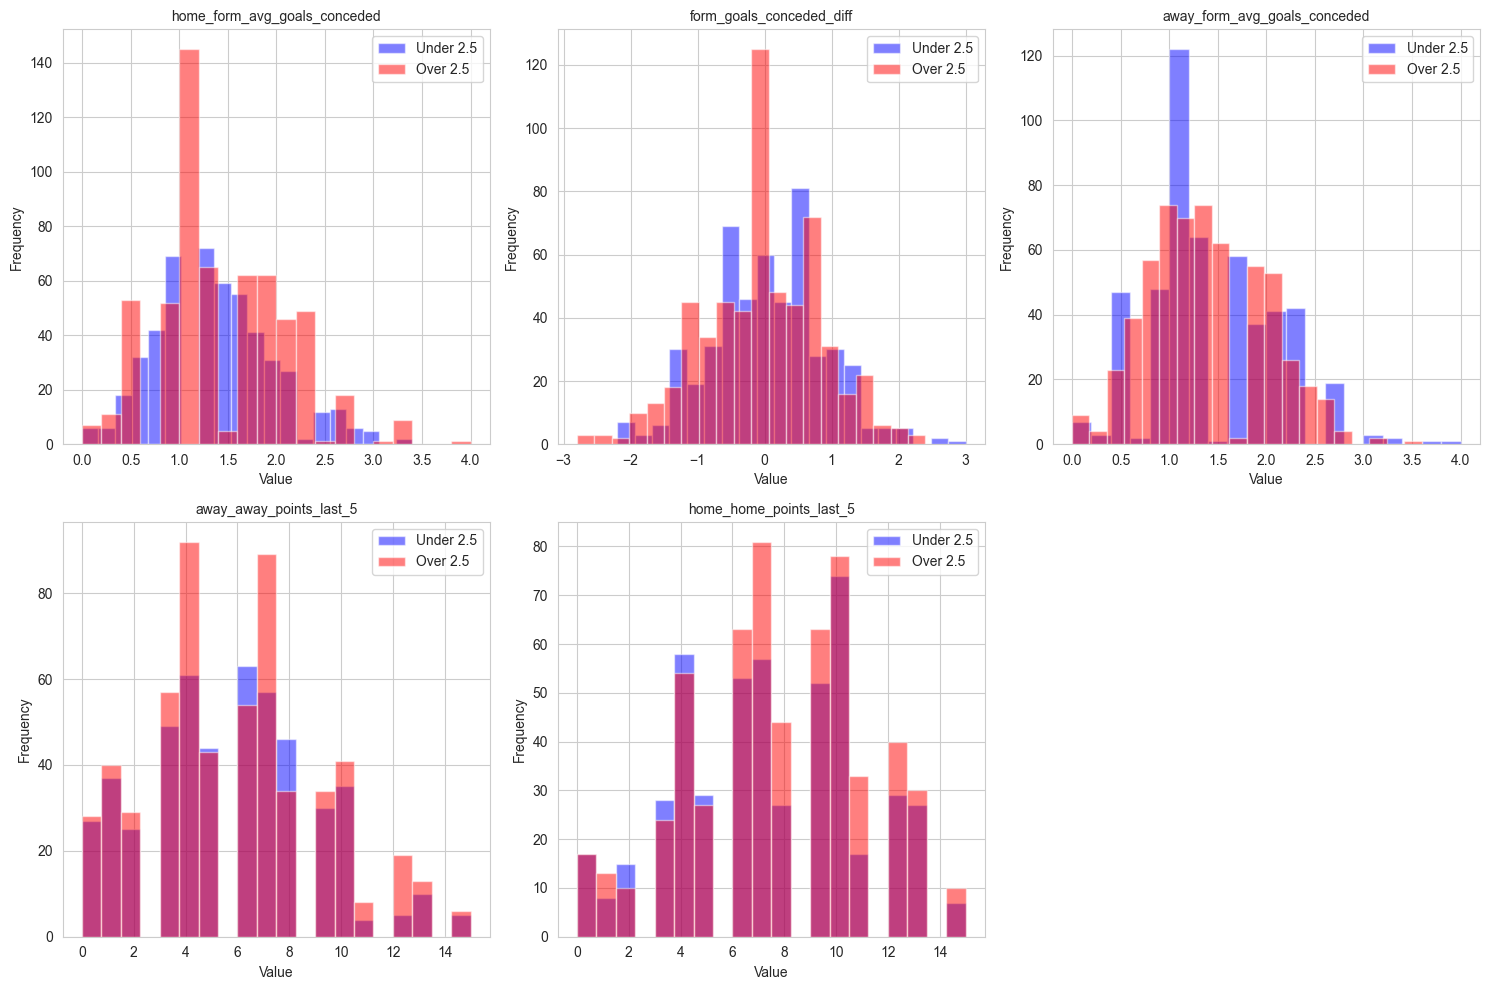


If distributions overlap heavily, feature isn't predictive!


In [11]:
# %% Cell 11: VISUALIZATION - What's Actually Predictive?

print("\n" + "="*60)
print("VISUALIZATION: FEATURE EFFECTIVENESS")
print("="*60)

# Show actual vs predicted for top features
top_5_features = feature_importance.head(5)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_5_features):
    # Split by outcome
    over = data[data['over_2_5'] == 1][feature]
    under = data[data['over_2_5'] == 0][feature]
    
    axes[idx].hist(under, alpha=0.5, label='Under 2.5', bins=20, color='blue')
    axes[idx].hist(over, alpha=0.5, label='Over 2.5', bins=20, color='red')
    axes[idx].set_title(feature, fontsize=10)
    axes[idx].legend()
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\nIf distributions overlap heavily, feature isn't predictive!")

In [12]:
# %% Cell 12: RECOMMENDATION - What to Do Next

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

results_summary = pd.DataFrame({
    'Approach': [
        'Original (Temporal split)',
        'Top 10 features only',
        'Random split (stratified)',
        'Best hyperparameters',
        'Filtered high-quality data'
    ],
    'Accuracy': [
        '42.4%',
        f'{acc_top10*100:.1f}%',
        f'{acc_rand*100:.1f}%',
        f'{acc_best*100:.1f}%',
        f'{acc_filtered*100:.1f}%' if 'acc_filtered' in locals() else 'N/A'
    ]
})

print("\nResults Summary:")
print(results_summary.to_string(index=False))

print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)

if acc_rand > 0.55:
    print("\n✅ GOOD NEWS: Random split works better!")
    print("\nActions:")
    print("1. Use random/stratified split instead of temporal")
    print("2. Your features ARE predictive, just not across time")
    print("3. Retrain model weekly with latest data")
    print("4. Consider adding more recent matches via API")
    
elif acc_best > 0.50:
    print("\n✅ MODERATE: Hyperparameters help!")
    print("\nActions:")
    print("1. Use optimized hyperparameters")
    print("2. Try ensemble methods (stacking, blending)")
    print("3. Add more engineered features")
    
else:
    print("\n❌ FUNDAMENTAL ISSUE: Features lack predictive power")
    print("\nActions:")
    print("1. ⚠️ PRIORITY: Collect MORE data (aim for 2000+ matches)")
    print("2. Add API features: player lineups, injuries, form ratings")
    print("3. Add weather data (rain affects scoring)")
    print("4. Try different feature windows (last 3, last 10 matches)")
    print("5. Consider league-specific models (each league separately)")
    print("6. Add fixture difficulty ratings")
    print("7. Include betting odds as features (market wisdom)")

print("\n" + "="*60)
print("Remember: 50-55% for Over/Under is actually respectable!")
print("Professional models typically achieve 55-60%.")
print("="*60)


RECOMMENDATIONS

Results Summary:
                  Approach Accuracy
 Original (Temporal split)    42.4%
      Top 10 features only    53.0%
 Random split (stratified)    48.4%
      Best hyperparameters    51.6%
Filtered high-quality data    54.3%

NEXT STEPS:

✅ MODERATE: Hyperparameters help!

Actions:
1. Use optimized hyperparameters
2. Try ensemble methods (stacking, blending)
3. Add more engineered features

Remember: 50-55% for Over/Under is actually respectable!
Professional models typically achieve 55-60%.
